0. 경로 설정

In [19]:
import os

os.getcwd()
base_dir = 'D:/Dacon_Art_Classification/Art_Classification'
data_dir = "D:/Dacon_Art_Classification/data"

1. Dataset 만들기

In [20]:
import torch
from torch.utils.data import DataLoader, Dataset,random_split
from torchvision import transforms
import torch.nn.functional as F
import pandas as pd
import numpy as np
import cv2

class CustomDataset(Dataset):
    
    def __init__(self, state,img_dir, label:pd.DataFrame=None, transform=None):
        self.state = state
        self.label = label
        self.img_dir = img_dir
        self.transform = transform
    def __len__(self):
        return len(self.label)
    def __getitem__(self, idx):
        # linux일때 '/' 바꿔서 돌리기
        if self.state =='train':
            img_path = os.path.join(self.img_dir,"train",self.label['img_path'][idx].split('/')[-1])
            img_label = self.label['artist'][idx]
            img = cv2.imread(img_path)
            if self.transform:
                img = self.transform(img)
                
            img_label = F.one_hot(torch.Tensor([img_label]).to(torch.int64),num_classes = 50)
            return img,img_label
        else:
            img_path = os.path.join(self.img_dir,"test",self.label['img_path'][idx].split('/')[-1])
            img = cv2.imread(img_path)
            if self.transform:
                img = self.transform(img)
            return img
train_label = pd.read_csv(f'{data_dir}/train.csv')
test_label = pd.read_csv(f'{data_dir}/test.csv')

label_dict = dict(zip(train_label['artist'].unique(),range(50)))
print(label_dict)

train_label['artist'] = [label_dict[i] for i in train_label['artist']]

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((300, 300)), 
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((300, 300)), 
    transforms.ToTensor(),
])


{'Diego Velazquez': 0, 'Vincent van Gogh': 1, 'Claude Monet': 2, 'Edgar Degas': 3, 'Hieronymus Bosch': 4, 'Pierre-Auguste Renoir': 5, 'Rene Magritte': 6, 'Michelangelo': 7, 'Peter Paul Rubens': 8, 'Caravaggio': 9, 'Alfred Sisley': 10, 'Edouard Manet': 11, 'Rembrandt': 12, 'Francisco Goya': 13, 'Pablo Picasso': 14, 'Titian': 15, 'Mikhail Vrubel': 16, 'Leonardo da Vinci': 17, 'Kazimir Malevich': 18, 'Andy Warhol': 19, 'Vasiliy Kandinskiy': 20, 'Gustav Klimt': 21, 'Amedeo Modigliani': 22, 'Henri Rousseau': 23, 'Salvador Dali': 24, 'Pieter Bruegel': 25, 'Albrecht Du rer': 26, 'Paul Gauguin': 27, 'Sandro Botticelli': 28, 'Piet Mondrian': 29, 'Eugene Delacroix': 30, 'Paul Klee': 31, 'William Turner': 32, 'Marc Chagall': 33, 'Jan van Eyck': 34, 'Henri Matisse': 35, 'El Greco': 36, 'Gustave Courbet': 37, 'Andrei Rublev': 38, 'Jackson Pollock': 39, 'Edvard Munch': 40, 'Camille Pissarro': 41, 'Raphael': 42, 'Henri de Toulouse-Lautrec': 43, 'Joan Miro': 44, 'Giotto di Bondone': 45, 'Diego Rivera'

In [21]:
img_label = F.one_hot(torch.Tensor([5]).to(torch.int64),num_classes = 50)
print(img_label)

tensor([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])


In [22]:
Custom_data = CustomDataset('train',data_dir,train_label,train_transform)
train_set_size = int(len(Custom_data) * 0.8)
valid_set_size = int(len(Custom_data)-train_set_size )

train_set, valid_set = random_split(Custom_data, [train_set_size, valid_set_size])

train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_set, batch_size=32, shuffle=True)

test_data = CustomDataset('test',data_dir,test_label,test_transform)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

2. 모델 만들기

In [23]:
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn
model_pretrained = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

num_ftrs = model_pretrained.fc.in_features

model_pretrained.fc = nn.Sequential(
    nn.Linear(num_ftrs,200,bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(200, 50),
    nn.ReLU(inplace=True))
print(model_pretrained)
#이거 쓰는 법도 공부해보기

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pretrained_model = model_pretrained.to(device)
x = torch.randn(3, 3, 224, 224).to(device)
pretrained_output = model_pretrained(x)
print(pretrained_output.size())

from torchsummary import summary
summary(pretrained_model, (3, 224, 224), device=device.type)

torch.Size([3, 50])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-1

In [88]:
import torch.optim as optim
from tqdm import tqdm
print("start train")
#criterion = nn.MultiLabelSoftMarginLoss()
#criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()
#optimizer = optim.SGD(pretrained_model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(pretrained_model.parameters(), lr=0.0001)

num_epochs = 10
pretrained_model.train()
# train_dataloader에 문제 발생한듯
loss_sum = []
for epoch in range(num_epochs):
    print("epoch is :",epoch)
    for i, (images,labels) in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad() # 1. optimizer 초기화

        images = images.to(device)
        labels = torch.tensor(labels).to(device)
        outputs = pretrained_model(images)
        loss = criterion(outputs,labels.reshape(-1,50).float())
        loss_sum.append(loss)
        loss.backward()
        optimizer.step() 
    print(f'loss is : {loss}')

start train
epoch is : 0


  0%|                                                                                          | 0/148 [00:00<?, ?it/s]C:\Users\kimju\AppData\Local\Temp\ipykernel_22168\1128831933.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)
100%|████████████████████████████████████████████████████████████████████████████████| 148/148 [01:29<00:00,  1.65it/s]


loss is : 0.6931471824645996
epoch is : 1


100%|████████████████████████████████████████████████████████████████████████████████| 148/148 [01:31<00:00,  1.61it/s]


loss is : 0.6931471824645996
epoch is : 2


100%|████████████████████████████████████████████████████████████████████████████████| 148/148 [01:33<00:00,  1.58it/s]


loss is : 0.6931471824645996
epoch is : 3


100%|████████████████████████████████████████████████████████████████████████████████| 148/148 [01:34<00:00,  1.56it/s]


loss is : 0.6931471824645996
epoch is : 4


100%|████████████████████████████████████████████████████████████████████████████████| 148/148 [01:36<00:00,  1.53it/s]


loss is : 0.6931471824645996
epoch is : 5


100%|████████████████████████████████████████████████████████████████████████████████| 148/148 [01:42<00:00,  1.45it/s]


loss is : 0.6931471824645996
epoch is : 6


100%|████████████████████████████████████████████████████████████████████████████████| 148/148 [03:10<00:00,  1.29s/it]


loss is : 0.6931471824645996
epoch is : 7


100%|████████████████████████████████████████████████████████████████████████████████| 148/148 [03:29<00:00,  1.42s/it]


loss is : 0.6931471824645996
epoch is : 8


100%|████████████████████████████████████████████████████████████████████████████████| 148/148 [03:30<00:00,  1.42s/it]


loss is : 0.6931471824645996
epoch is : 9


100%|████████████████████████████████████████████████████████████████████████████████| 148/148 [03:30<00:00,  1.43s/it]

loss is : 0.6931471824645996


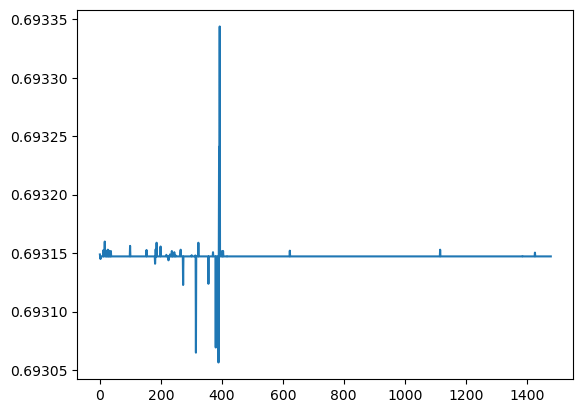

In [89]:
loss_sum = [i.item() for i in loss_sum]
import matplotlib.pyplot as plt
plt.plot(loss_sum)

In [28]:
torch.save(pretrained_model,"pretrained_model.pt")

In [30]:
import torch
from tqdm import tqdm
from torchvision import transforms
test_data = CustomDataset('test',data_dir,test_label,test_transform)
test_dataloader = DataLoader(test_data, batch_size=16, shuffle=True)
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((300, 300)), 
    transforms.ToTensor(),
])
#valid_model = torch.load('model.pt')
valid_model = pretrained_model
valid_model.eval()
out_list = []
label_list= []
with torch.no_grad():
    for i,(image,label) in enumerate(tqdm(valid_dataloader)):
        image = image.to(device)
        out = valid_model(image)
        out_list.append(out)
        label_list.append(label)

100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:19<00:00,  1.90it/s]


In [83]:
#print(len(label_list[0]))
k = [np.argmax(i,axis=2).flatten() for i in label_list]
final_label = []
for i in k:
    final_label+=i
final_label = [i.item() for i in final_label]
print(len(final_label))

1183


In [84]:
#final_label = []
#for i in label_list:
#    for j in i:
#        final_label.append(j.item())
#print(len(final_label))

In [85]:
final_class = [(i.argmax(axis=1).to('cpu')) for i in out_list]
final_output = []
for i in final_class:
    for j in i:
        final_output.append(j.item())
print(len(final_output))

1183


In [86]:
from sklearn.metrics import accuracy_score

accuracy_score(final_label,final_output)

0.02197802197802198

In [171]:
#epoch = 10 일때 0.10312764158918004

In [ ]:
#epoch = 50 일 때 0.18258664412510567

In [ ]:
#epoch = 90 일 때 0.22147083685545224

In [ ]:
#epoch = 200 일 때 0.27218934911242604

In [55]:
import torch.nn.functional as F

In [60]:
F.one_hot(,num_classes = 50)

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])